# Test Project - Asset Management

Implemented by Andrew Muschamp McKay andrew@muschamp.ca Sunday October 26th 2025

##  Instructions

**Class-Based Implementation of Mean-Variance Portfolios**

Implement a class that does the following:

* uses the data set `https://hilpisch.com/indices_eikon_eod_data.csv` [Done]
* allows to define the investable universe (= set of instruments to be used) [Done]
* assumes that 100% of a capital base is to be invested (normalized portfolios) [Done]
* allows to define whether short sales are allowed or not [Done]
* allows to define a maximum (in negative %) for any short position (say, `-0.1` for "10% short") [Done]
* calculates for an arbitraty portfolio composition (in line with the before assumptions/constraints) the expected return and the volatility of the portfolio [Done]
* simulates random portfolio compositions including risk-return statistics and allows for the visualization of these statistics [Done]
* uses optimization techniques with freely defined bounds (say, "every asset shall have a minimum allocation of 5%") to ...
    * ... derive the minimum risk portfolio [Done]
    * ... derive the maximum Sharpe portfolio [Done]
    * ... derive and visualize the efficient frontier

## Imports and Data

In [6]:
import math
import numpy as np
import pandas as pd
from pylab import plt
from scipy.optimize import minimize
plt.style.use('seaborn-v0_8')
pd.set_option("display.precision", 5)
np.set_printoptions(suppress=True,
        formatter={'float': lambda x: f'{x:.4f}'})

In [7]:
import warnings
warnings.filterwarnings('ignore') # I get a RuntimeWarning Values in x were outside bounds sometimes, this hides them

In [8]:
url = 'https://hilpisch.com/indices_eikon_eod_data.csv'

In [9]:
raw = pd.read_csv(url,
                  index_col=0, parse_dates=True).dropna()

In [10]:
# raw

In [11]:
rets = np.log(raw / raw.shift(1)).dropna()

In [12]:
## rets

In [13]:
universe = rets.columns[:]

In [14]:
universe

Index(['.FCHI', '.FTSE', '.GDAXI', '.HSI', '.NDX', '.NSEI', '.SPX', '.SSEC'], dtype='object')

## Define Class

In [16]:
class AssetManager:
    def __init__(self, 
                 market=rets, 
                 holdings=None, 
                 short_sales_allowed=False, 
                 max_short_size=-0.1, 
                 min_position_size=0.0, 
                 max_position_size=1.0):
        # some checking of the passed in returns would be wise, I also like private variables/functions
        self.market=rets
        if holdings is None:
            self.holdings = self.market.columns[:]
        else:
            self.holdings = holdings
        self.our_returns=self.market[self.holdings]
        self.noa = len(self.holdings)
        self.short_sales_allowed = short_sales_allowed
        if self.short_sales_allowed:
            if (1 + (self.noa * max_short_size * -1)) > max_position_size:
                self.bnds = tuple((max_short_size, max_position_size) for x in range(self.noa))
            else:
                self.bnds = tuple((max_short_size, (1 + (self.noa * max_short_size * -1))) for x in range(self.noa))
        else:
            self.bnds = tuple((min_position_size, max_position_size) for x in range(self.noa))
        self.cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        self.equal_weights = self.noa * [1 / self.noa]

    # Had to make two static and one class method to get it all to work  
    @staticmethod        
    def annualized_return(rets, weights):
        return np.dot(rets.mean(), weights) * 252  # annualized

    @staticmethod
    def annualized_volatility(rets, weights):
        return math.sqrt(np.dot(weights, np.dot(rets.cov() * 252 , weights)))

    @classmethod
    def sharpe_ratio(cls, rets, weights):
        return cls.annualized_return(rets, weights) / cls.annualized_volatility(rets, weights)

    def simulate_random_portfolios(self, simulations=2500):
        simulated_returns = []
        simulated_volatilities = []
        for p in range (simulations):
            weights = np.random.random(self.noa)
            weights /= np.sum(weights)
            simulated_returns.append(AssetManager.annualized_return(self.our_returns, weights))
            simulated_volatilities.append(AssetManager.annualized_volatility(self.our_returns, weights))
        simulated_returns = np.array(simulated_returns)
        simulated_volatilities = np.array(simulated_volatilities)
        return simulated_returns, simulated_volatilities

    def visualize_random_portfolios(self, simulations=2500):
        prets, pvols = self.simulate_random_portfolios(simulations)
        plt.figure(figsize=(10,6))
        plt.scatter(pvols, prets, c=prets / pvols,
                    marker='o', cmap='coolwarm')
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe ratio')
        plt.show();

    def minimum_risk_portfolio(self):
        opt = minimize(lambda weights: AssetManager.annualized_volatility(self.our_returns, weights),
                       self.equal_weights, 
                       bounds=self.bnds, 
                       constraints=self.cons)
        return opt['x']

    def maximum_sharpe_portfolio(self):
        opt = minimize(lambda weights: -AssetManager.sharpe_ratio(self.our_returns, weights),
                       self.equal_weights,
                       bounds=self.bnds,
                       constraints=self.cons)
        return opt['x']

    def visualize_efficient_frontier(self, simulations=2500, min_return=0.0, max_return=0.2):
        extra_cons = ({'type': 'eq', 'fun': lambda weights: AssetManager.annualized_return(self.our_returns, weights) - tret},
                      self.cons)
        trets = np.linspace(min_return, max_return, 50)
        tvols = []
        for tret in trets:
            res = minimize(lambda weights: AssetManager.annualized_volatility(self.our_returns, weights),
                           self.equal_weights,
                           method='SLSQP',
                           bounds=self.bnds,
                           constraints=extra_cons)
            tvols.append(res['fun'])
        tvols = np.array(tvols)
        prets, pvols = self.simulate_random_portfolios(simulations)
        mrweights = self.minimum_risk_portfolio()
        msweights = self.maximum_sharpe_portfolio()
        plt.figure(figsize=(10, 6))
        plt.scatter(pvols, prets, c=prets / pvols,
                    marker='.', alpha=0.8, cmap='coolwarm')
        plt.plot(tvols, trets, 'b', lw=4.0, label='Efficient Frontier')
        plt.plot(self.annualized_volatility(self.our_returns, msweights),
                 self.annualized_return(self.our_returns, msweights),
                 'y*', markersize=15.0, label='Maximum Sharpe Portfolio')
        plt.plot(self.annualized_volatility(self.our_returns, mrweights),
                 self.annualized_return(self.our_returns, mrweights),
                  'r*', markersize=15.0, label='Minimum Risk Portfolio')
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe ratio')
        plt.legend()
        plt.show();

### Class testing code

In [18]:
symbols = ['.FCHI', '.FTSE', '.GDAXI']
# portfolio = AssetManager(holdings=symbols)
# portfolio = AssetManager(holdings=symbols, min_position_size=0.05)
portfolio = AssetManager(holdings=symbols, short_sales_allowed=True, max_short_size=-0.15, max_position_size=1.2)

In [19]:
portfolio.market

,.FCHI,.FTSE,.GDAXI,.HSI,.NDX,.NSEI,.SPX,.SSEC
Date,,,,,,,,
2016-01-05,0.00335,0.00716,0.00259,-0.00651,-0.00305,-0.00085,0.00201,-0.00260
2016-01-06,-0.01268,-0.01046,-0.00936,-0.00986,-0.00900,-0.00562,-0.01320,0.02230
2016-01-07,-0.01731,-0.01984,-0.02319,-0.03135,-0.03161,-0.02256,-0.02399,-0.07305
2016-01-08,-0.01598,-0.00702,-0.01316,0.00590,-0.00815,0.00436,-0.01090,0.01946
2016-01-11,-0.00486,-0.00689,-0.00247,-0.02802,0.00298,-0.00495,0.00085,-0.05473
...,...,...,...,...,...,...,...,...
2020-12-21,-0.02463,-0.01744,-0.02859,-0.00727,-0.00377,-0.03191,-0.00391,0.00753
2020-12-22,0.01354,0.00573,0.01289,-0.00715,0.00215,0.01029,-0.00208,-0.01882
2020-12-23,0.01105,0.00658,0.01253,0.00853,-0.00508,0.00996,0.00075,0.00758


In [20]:
portfolio.holdings

['.FCHI', '.FTSE', '.GDAXI']

In [21]:
portfolio.our_returns

,.FCHI,.FTSE,.GDAXI
Date,,,
2016-01-05,0.00335,0.00716,0.00259
2016-01-06,-0.01268,-0.01046,-0.00936
2016-01-07,-0.01731,-0.01984,-0.02319
2016-01-08,-0.01598,-0.00702,-0.01316
2016-01-11,-0.00486,-0.00689,-0.00247
...,...,...,...
2020-12-21,-0.02463,-0.01744,-0.02859
2020-12-22,0.01354,0.00573,0.01289
2020-12-23,0.01105,0.00658,0.01253


In [22]:
portfolio.noa

3

In [23]:
portfolio.short_sales_allowed

True

In [24]:
# portfolio.max_short_sales # I chose to just created the bnds right away based on what was passed in

In [25]:
portfolio.bnds

((-0.15, 1.2), (-0.15, 1.2), (-0.15, 1.2))

In [26]:
portfolio.cons

{'type': 'eq',
 'fun': <function __main__.AssetManager.__init__.<locals>.<lambda>(weights)>}

In [27]:
weights = portfolio.equal_weights
weights

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [28]:
portfolio.annualized_return(portfolio.our_returns, weights)

0.04455566733671525

In [29]:
portfolio.annualized_volatility(portfolio.our_returns, weights)

0.1997938944828696

In [30]:
portfolio.sharpe_ratio(portfolio.our_returns, weights)

0.22300815273679683

In [31]:
sim_rets, sim_vols = portfolio.simulate_random_portfolios()

In [32]:
sim_rets.mean()

0.04474935797843564

In [33]:
sim_vols.mean()

0.20101243040054886

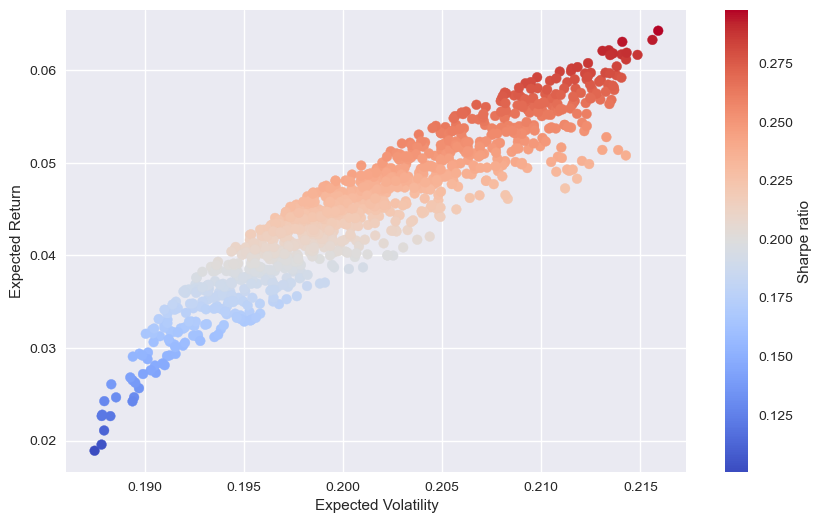

In [34]:
portfolio.visualize_random_portfolios(1000)

In [35]:
minimum_risk_weights = portfolio.minimum_risk_portfolio() # I get a RuntimeWarning Values in x were outside bounds sometimes

In [36]:
minimum_risk_weights

array([-0.1500, 1.0181, 0.1319])

In [37]:
portfolio.annualized_volatility(portfolio.our_returns, minimum_risk_weights)

0.18699872301879

In [38]:
portfolio.annualized_return(portfolio.our_returns, minimum_risk_weights)

0.018702203933927745

In [39]:
maximum_sharpe_weights = portfolio.maximum_sharpe_portfolio() # I get a RuntimeWarning Values in x were outside bounds sometimes

In [40]:
maximum_sharpe_weights

array([-0.0500, -0.1500, 1.2000])

In [41]:
portfolio.sharpe_ratio(portfolio.our_returns, maximum_sharpe_weights)

0.329875830950756

In [42]:
portfolio.annualized_return(portfolio.our_returns, maximum_sharpe_weights)

0.07537342272789078

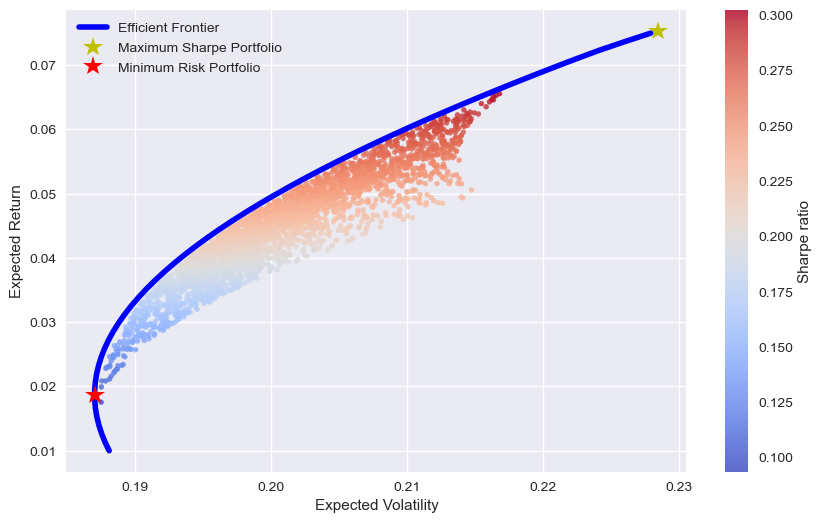

In [43]:
portfolio.visualize_efficient_frontier(3000, 0.01, 0.075) # The return of the maximum sharpe portfolio guides last value